<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/DEEPFAKE_AUDIO_DETECTION_TRANSFER_LEARNING_MODELS_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install wandb

In [ ]:
# import necessary libraries
import wandb
from wandb.keras import WandbCallback
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize wandb
wandb.login()
wandb.init(project='DeepFake Audio Detection', entity='ruoro',
           config = {
               'learning_rate': 0.005,
               'epochs': 5,
               'batch_size': 4,
               'loss_function':"binary_crossentropy"
           }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# define train and test data
from PIL import Image
import glob
train_path = []
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Spoof/*.png'):
    im=Image.open(filename)
    train_path.append(im)
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/*.png'):
    im=Image.open(filename)
    train_path.append(im)
from PIL import Image
import glob
valid_path = []
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/*.png'):
    im=Image.open(filename)
    valid_path.append(im)
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/*.png'):
    im=Image.open(filename)
    valid_path.append(im)

In [ ]:
# add preprocessing layer to the front of VGG
# the include_top false statement will allow us to be able to set the number of classes on the top layer that we will create
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train - vgg has existing weights
for layer in vgg.layers:
  layer.trainable = False
  
 
  # useful for getting number of classes
  # this will count the number of classes we have in our dataset assuming that the data is grouped into specific folders
folders = 1 #glob('Datasets/Train/*')

In [ ]:
# our layers
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(folders, activation='sigmoid')(x)


In [ ]:

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/',
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'binary')





Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
 # fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch= 20, #len(training_set),
  validation_steps= 20, #len(test_set),
  callbacks=[WandbCallback()]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
20/20 [==============================] - 64s 3s/step - loss: 0.7754 - accuracy: 0.6875 - val_loss: 1.2484 - val_accuracy: 0.5375
Epoch 2/5
20/20 [==============================] - 66s 3s/step - loss: 0.6705 - accuracy: 0.7250 - val_loss: 0.8477 - val_accuracy: 0.6500
Epoch 3/5
20/20 [==============================] - 63s 3s/step - loss: 0.4761 - accuracy: 0.7875 - val_loss: 1.1986 - val_accuracy: 0.5750
Epoch 4/5
20/20 [==============================] - 64s 3s/step - loss: 0.7781 - accuracy: 0.6500 - val_loss: 1.4934 - val_accuracy: 0.5125
Epoch 5/5
20/20 [==============================] - 67s 3s/step - loss: 0.8215 - accuracy: 0.6875 - val_loss: 0.8583 - val_accuracy: 0.6500


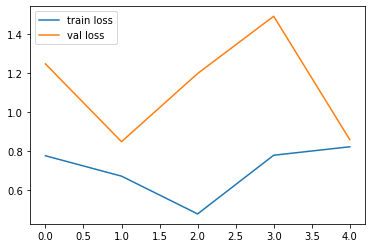

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')



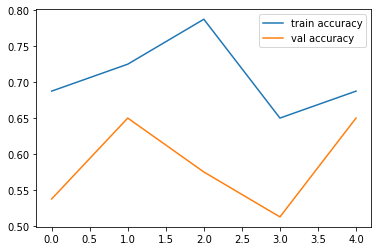

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('DeepFakeVGG16Model.h5')
